# Text pipeline
Text Pipeline: 

Current sentence + Emotion + context + NER + keyword  --[T5-fintuned-CommonGen]--> next sentence

In [ ]:
!pip install SentencePiece
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 20.9 MB/s 
     |████████████████████████████████| 596 kB 39.9 MB/s 
     |████████████████████████████████| 101 kB 2.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.1 MB/s 
     |████████████████████████████████| 140 kB 55.3 MB/s 
     |████████████████████████████████| 212 kB 46.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.0 MB/s 
     |██████████████████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Stry233/A-Emotion-Data-Cleaning-Pipeline-for-Enhancing-Data-Reliability.git

Cloning into 'A-Emotion-Data-Cleaning-Pipeline-for-Enhancing-Data-Reliability'...
remote: Enumerating objects: 890, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 890 (delta 81), reused 169 (delta 81), pack-reused 718
Receiving objects: 100% (890/890), 202.97 MiB | 11.66 MiB/s, done.
Resolving deltas: 100% (572/572), done.
Checking out files: 100% (299/299), done.


## Current sentence

In [ ]:
import pandas as pd
# storyData = pd.read_csv('../../data/csv_version/dev/emotion/allcharlinepairs-clean-v1.csv') # local
storyData = pd.read_csv('./A-Emotion-Data-Cleaning-Pipeline-for-Enhancing-Data-Reliability/data/csv_version/dev/emotion/allcharlinepairs-clean-v1.csv', index_col=0)
sentenceIndex = storyData[storyData['context'].isna()].sample()['sentence'].index
demoStory = storyData.iloc[sentenceIndex[0]:sentenceIndex[0]+5]
demoSentence = demoStory.iloc[0]['sentence']
print(demoSentence)
demoStory


Lee loved motorcycles.


storyid  linenum       char  \
6382  3710a9d2-d737-40bb-bf4d-ee819d020b8a        1        Lee   
6383  3710a9d2-d737-40bb-bf4d-ee819d020b8a        2        Lee   
6384  3710a9d2-d737-40bb-bf4d-ee819d020b8a        3        Lee   
6385  3710a9d2-d737-40bb-bf4d-ee819d020b8a        4        Lee   
6386  3710a9d2-d737-40bb-bf4d-ee819d020b8a        5  Lee's dad   

     emotionworkerid                                            context  \
6382            ann0                                                NaN   
6383            ann0                             Lee loved motorcycles.   
6384            ann0  Lee loved motorcycles.|When he turned 16, his ...   
6385            ann0  Lee loved motorcycles.|When he turned 16, his ...   
6386            ann0  Lee loved motorcycles.|When he turned 16, his ...   

                                               sentence affected  \
6382                             Lee loved motorcycles.      yes   
6383  When he turned 16, his dad gave him an old mot...      yes   
6384                                  Lee was thrilled.      yes   
6385  He went to the DMV and signed up for the bike ...      yes   
6386  He passed on the first try and soon was drivin...      yes   

                                                emotion  \
6382  ['happy', 'excited', 'pleased', 'loving', 'eng...   
6383                      ['joy', 'ecstatic', 'elated']   
6384                    ['static', 'happy', 'grateful']   
6385  ['hopeful', 'excited', 'happy', 'nervous', 'an...   
6386  ['proud', 'happy', 'overjoyed', 'elated', 'acc...   

                                               plutchik  
6382  {'joy': 3, 'trust': 0, 'fear': 0, 'surprise': ...  
6383  {'joy': 3, 'trust': 1, 'fear': 0, 'surprise': ...  
6384  {'joy': 3, 'trust': 2, 'fear': 0, 'surprise': ...  
6385  {'joy': 2, 'trust': 1, 'fear': 0, 'surprise': ...  
6386  {'joy': 2, 'trust': 1, 'fear': 0, 'surprise': ...

## Emotion

In [ ]:
import warnings
import pandas as pd
import ast
import random

In [ ]:
attributes = ['joy','trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation']
# dataDevPlutchik = pd.read_csv('allcharlinepairs.csv') #text file
dataDevPlutchik = storyData
dataDevPlutchik['plutchik'] = [ast.literal_eval(x) for x in dataDevPlutchik['plutchik']]
print(dataDevPlutchik['plutchik'][0], len(dataDevPlutchik['plutchik'][0]))

{'joy': 2, 'trust': 1, 'fear': 0, 'surprise': 1, 'sadness': 0, 'disgust': 0, 'anger': 0, 'anticipation': 2} 8


In [ ]:
results = dict()

currid = dataDevPlutchik['storyid'][0]
counter = 0
labels = []
emotions = []
ans = []
err = 0
trainset = []
while(counter < len(dataDevPlutchik)):
    tcounter = 0
    while(dataDevPlutchik['storyid'][counter + tcounter]==currid):
        tstr = ""
        for k in dataDevPlutchik['plutchik'][counter+tcounter].keys():
            tstr += str(dataDevPlutchik['plutchik'][counter+tcounter][k])
            
        
        tcounter += 1
        if(counter + tcounter >= len(dataDevPlutchik)):
            break
        
        if(tstr != ''):
            if(tstr not in results.keys()):
                results[tstr] = [0 for u in range(9)]
            results[tstr][8] += 1
            tstr1 = ""
            for k in dataDevPlutchik['plutchik'][counter+tcounter].keys():
                if(int(dataDevPlutchik['plutchik'][counter+tcounter][k]) > 0):
                    tstr1 += '1'
                    num = attributes.index(k)
                    results[tstr][num] += 1
                else:
                    tstr1 += '0'
            trainset.append(tstr+' '+tstr1)
                
    if(counter + tcounter >= len(dataDevPlutchik)):
        break
    currid = dataDevPlutchik['storyid'][counter+tcounter]
    counter += tcounter
print(len(results))

print(results)

2002
{'21010002': [116, 87, 24, 76, 23, 12, 14, 112, 138], '23000002': [3, 2, 1, 3, 2, 0, 2, 4, 5], '11000001': [77, 60, 26, 55, 27, 20, 23, 84, 119], '00130320': [0, 0, 0, 1, 1, 1, 1, 0, 1], '00012310': [0, 0, 0, 0, 1, 1, 0, 0, 1], '00002100': [7, 4, 2, 2, 3, 3, 3, 7, 11], '10001001': [11, 7, 6, 11, 10, 2, 3, 12, 20], '20010001': [66, 40, 18, 40, 11, 11, 13, 64, 84], '32000000': [18, 11, 5, 9, 6, 3, 4, 17, 23], '20000000': [118, 83, 39, 83, 46, 34, 35, 120, 183], '00000120': [6, 2, 5, 10, 5, 9, 10, 7, 14], '00000020': [4, 2, 6, 9, 7, 6, 10, 7, 12], '11112111': [1, 1, 0, 0, 0, 0, 1, 1, 2], '10000010': [7, 2, 1, 5, 1, 3, 4, 7, 10], '20010000': [39, 23, 10, 20, 11, 6, 3, 36, 54], '22010002': [84, 68, 14, 56, 14, 8, 12, 88, 102], '21000001': [243, 172, 64, 147, 64, 46, 51, 236, 321], '21000002': [184, 132, 54, 116, 51, 33, 27, 191, 248], '10211102': [0, 0, 1, 0, 1, 0, 1, 1, 1], '00201011': [1, 1, 2, 2, 2, 2, 2, 2, 3], '21010001': [181, 126, 39, 126, 41, 30, 26, 177, 238], '22020002': [16,

# GET NEXT SENTENCE EMOTION(Probability Distribution + Distance)

In [ ]:
for k in results.keys():
    for u in range(len(results[k])-1):
        results[k][u] = results[k][u]/results[k][8]
results

{'21010002': [0.8405797101449275,
  0.6304347826086957,
  0.17391304347826086,
  0.5507246376811594,
  0.16666666666666666,
  0.08695652173913043,
  0.10144927536231885,
  0.8115942028985508,
  138],
 '23000002': [0.6, 0.4, 0.2, 0.6, 0.4, 0.0, 0.4, 0.8, 5],
 '11000001': [0.6470588235294118,
  0.5042016806722689,
  0.2184873949579832,
  0.46218487394957986,
  0.226890756302521,
  0.16806722689075632,
  0.19327731092436976,
  0.7058823529411765,
  119],
 '00130320': [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1],
 '00012310': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1],
 '00002100': [0.6363636363636364,
  0.36363636363636365,
  0.18181818181818182,
  0.18181818181818182,
  0.2727272727272727,
  0.2727272727272727,
  0.2727272727272727,
  0.6363636363636364,
  11],
 '10001001': [0.55, 0.35, 0.3, 0.55, 0.5, 0.1, 0.15, 0.6, 20],
 '20010001': [0.7857142857142857,
  0.47619047619047616,
  0.21428571428571427,
  0.47619047619047616,
  0.13095238095238096,
  0.13095238095238096,
  0.15476190476190

In [ ]:
def getEmoDist(emolastsent):
    ret = sorted(set(random.choices(attributes, results[emolastsent][:8], k=8)))
    if(emolastsent in results.keys()):
        return ', '.join(list(ret))
    emokey = list(results.keys())
    mindist = 1000
    ridx = ""
    for i in range(len(emokey)):
        dist = 0
        for j in range(len(emokey[i])):
            dist += ((int(emokey[i][j])-int(emolastsent[j]))**2)**(0.5)
        if(dist<mindist):
            mindist = dist
            ridx = emokey[i]
    ret = sorted(set(random.choices(attributes, results[ridx][:8], k=8)))
    return ', '.join(list(ret))

# GET NEXT SENTENCE EMOTION(Probability Distribution + Bert Model)

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np

# joy, trust, fear, surprise, sadness, disgust, anger, anticipation
emotionActivate =  {'joy' : True, 
            'trust' : True, 
            'fear' : True, 
            'surprise' : True, 
            'sadness' : True, 
            'disgust' : True, 
            'anger' : True, 
            'anticipation' : True}

import torch
def genEmo(demoSentenceInput):
    # model = AutoModelForSequenceClassification.from_pretrained("./firstSentenceDetection/") # local
    model = AutoModelForSequenceClassification.from_pretrained("Yuetian/bert-base-uncased-finetuned-plutchik-emotion") # local
    # assert model.config.output_attentions == True
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
      
    encoding = tokenizer(demoSentenceInput, return_tensors="pt")
    # tokenizer.decode(encoding['input_ids'])
    encoding = {k: v.to('cpu') for k,v in encoding.items()}

    outputs = model(**encoding)
    
    # apply sigmoid + threshold
    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.5)] = 1
    # turn predicted id's into actual label names
    predicted_labels = [list(emotionActivate.keys())[idx] for idx, label in enumerate(predictions) if label == 1.0 and list(emotionActivate.values())[idx] == True]
    return ", ".join( key for key in predicted_labels)

In [ ]:
genEmo("I am happy")

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

'joy, trust, anticipation'

In [ ]:
def getEmoBert(emolastsent, lastsent):
    #attr = [i for i in range(8)]
    ret = sorted(set(random.choices(attr, results[emolastsent][:8], k=8)))
    #ret = [attributes[i] for i in ret]
    if(emolastsent in results.keys()):
        return ', '.join(list(ret))
    return genEmo(lastsent)

## NER

In [ ]:
!pip install SceneGraphParser
!python -m spacy download en  
!pip install spacy

In [ ]:
import sng_parser
# TO-DO: GPT 2 generate keyword
def genKeyword(demoSentenceInput):
    graph = sng_parser.parse(demoSentenceInput)
    print(graph)
    majorKeyword = [x['span'] for x in graph['entities']]
    return ", ".join( key for key in majorKeyword)

In [ ]:
demoSentenceInput = "I and Ann were having a night walk yesterday"
graph = sng_parser.parse(demoSentenceInput)
graph

{'entities': [{'head': 'I',
   'lemma_head': 'I',
   'lemma_span': 'I',
   'modifiers': [],
   'span': 'I',
   'span_bounds': (0, 1),
   'type': 'unknown'},
  {'head': 'Ann',
   'lemma_head': 'Ann',
   'lemma_span': 'Ann',
   'modifiers': [],
   'span': 'Ann',
   'span_bounds': (2, 3),
   'type': 'unknown'},
  {'head': 'night walk',
   'lemma_head': 'night walk',
   'lemma_span': 'a night walk',
   'modifiers': [{'dep': 'det', 'lemma_span': 'a', 'span': 'a'}],
   'span': 'a night walk',
   'span_bounds': (5, 8),
   'type': 'unknown'}],
 'relations': [{'lemma_relation': 'have',
   'object': 2,
   'relation': 'having',
   'subject': 0},
  {'lemma_relation': 'have', 'object': 2, 'relation': 'having', 'subject': 1}]}

In [ ]:
genKeyword("I and Ann were having a night walk yesterday")

{'entities': [{'span': 'I', 'lemma_span': 'I', 'head': 'I', 'lemma_head': 'I', 'span_bounds': (0, 1), 'modifiers': [], 'type': 'unknown'}, {'span': 'Ann', 'lemma_span': 'Ann', 'head': 'Ann', 'lemma_head': 'Ann', 'span_bounds': (2, 3), 'modifiers': [], 'type': 'unknown'}, {'span': 'a night walk', 'lemma_span': 'a night walk', 'head': 'night walk', 'lemma_head': 'night walk', 'span_bounds': (5, 8), 'modifiers': [{'dep': 'det', 'span': 'a', 'lemma_span': 'a'}], 'type': 'unknown'}], 'relations': [{'subject': 0, 'object': 2, 'relation': 'having', 'lemma_relation': 'have'}, {'subject': 1, 'object': 2, 'relation': 'having', 'lemma_relation': 'have'}]}


'I, Ann, a night walk'

## Image Generation

In [ ]:
demoStory.iloc[4]['sentence']

#Disco Diffusion






# PreProcess text prompt


In [1]:
#Carl Spitzweg (decent
#Miyazaki Hayao (not working so well
#Cyberpunk (ok....)
#cartoon (not that ok..)
#Trending on artstation.

myPrompt = {"0": [ "city view", "Carl Spitzweg "]} #@param type="raw"

# Set Up disco diffusion Environment

In [3]:
#@title Set Up Environment
import os, sys
import subprocess, torch

#@markdown Leave these as defaults unless you know what you are doing.

use_google_drive = True #@param {type:"boolean"}
save_models = True #@param {type:"boolean"}
check_for_updates = True #@param {type:"boolean"}
content_root = '/content'
repo = "https://github.com/entmike/disco-diffusion-1" #@param {type:"string"}
branch = "main" #@param {type:"string"}
cwd = os.path.abspath('.')
is_local=True

if is_local: content_root=cwd
print (f'Current directory: {cwd}')

if use_google_drive == True:
  import os
  from google.colab import drive
  if os.path.isdir('/content/gdrive') == False:
    print(f'📁 Mounting Google Drive.  Please accept any confirmation screens.')
    drive.mount('/content/gdrive/')
  else:
    print(f'📁 Google Drive already mounted.')
  content_root = '/content/gdrive/MyDrive'

dd_root = f'{content_root}/disco-diffusion-1'

print(f'✅ Disco Diffusion root path will be "{dd_root}"')

is_colab = False
try:
    from google.colab import drive
    print("Google Colab detected.")
    is_colab=True
except:
    print("Google Colab not detected.")
    is_colab=False

root_path = dd_root

# Clone Repo
if os.path.isdir(f'{dd_root}') == False:
  print(f"Cloning repo '{repo}' into '{dd_root}'...")
  os.chdir(f'{content_root}')
  subprocess.run(f'git clone {repo}'.split(' '), stdout=subprocess.PIPE).stdout.decode("utf-8")

os.chdir(f'{dd_root}')
if check_for_updates == True:
  # Pull any updates
  print(f'📄 Pulling updates from GitHub...')
  for cmd in ['git clean -df', f'git checkout {branch}', f'git pull origin {branch}']:
    gitresults = subprocess.run(f'{cmd}'.split(' '), stdout=subprocess.PIPE).stdout.decode("utf-8")
    print(f'{gitresults}')
else:
  print("⚠️ Skipping checking for Git updates")

# Downgrade for T4/V100
device_name = torch.cuda.get_device_name(0)
print(f"🔍 You have a {device_name} GPU.")

#Upgrade pyyaml if in Colab
if is_colab:
    print(f'📦 Upgrading pyyaml...')
    subprocess.run(f'pip install --upgrade pyyaml --quiet'.split(' '), stdout=subprocess.PIPE).stdout.decode("utf-8")
    
    if "V100" in device_name or "T4" in device_name:
      print(f"⚠️ {torch.cuda.get_device_name(0)} detected.  Do not use ViTL14 or ViTL14@336 models...")
      # This causes problems with pytorch3d sigh... -Mike (5/13/22)
      # print("📦 Downgrading pytorch...")
      # downgrade_torch = subprocess.run('pip install torch==1.10.2 torchvision==0.11.3 -q'.split(' '), stdout=subprocess.PIPE).stdout.decode('utf-8')
      # import torch
    
    print(f'📦 Installing pip requirements...')
    piplog = subprocess.run(f'pip install -r colab-requirements.txt'.split(' '), stdout=subprocess.PIPE).stdout.decode("utf-8")
    # print(piplog)
# Set base project directory to current working directory
PROJECT_DIR = dd_root

# Import DD helper modules
sys.path.append(PROJECT_DIR)
import dd, dd_args

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


Current directory: /content
📁 Mounting Google Drive.  Please accept any confirmation screens.
Mounted at /content/gdrive/
✅ Disco Diffusion root path will be "/content/gdrive/MyDrive/disco-diffusion-1"
Google Colab detected.
📄 Pulling updates from GitHub...

M	docker/build-dev.sh
M	docker/build-main.sh
M	docker/build-runpod.sh
M	docker/jupyter.sh
M	docker/start.sh
M	docker/workermode.sh
M	docker/yaml.sh
M	examples/docker/disco-file.sh
M	examples/docker/disco.sh
M	examples/docker/interactive.sh
M	examples/docker/unittest.sh
M	examples/linux/configfile.sh
M	examples/linux/simple.sh
Your branch is up to date with 'origin/main'.

Already up to date.

🔍 You have a Tesla V100-SXM2-16GB GPU.
📦 Upgrading pyyaml...
⚠️ Tesla V100-SXM2-16GB detected.  Do not use ViTL14 or ViTL14@336 models...
📦 Installing pip requirements...


ModuleNotFoundError: ignored

# Set up Disco Diffusion Parameters

In [ ]:
from pydotted import pydot
args = pydot({})

#@markdown ##💡Batch/Config Parameters
#@markdown Specifies the folder name and filenames created in `images_out` to store your images.
args.batch_name = "TimeToDisco" #@param {type:"string"}
#@markdown If your batch run gets interrupted (either because you stopped it, or because of a disconnection) you can resume your batch run where you left off using this setting.  However, you MUST not change the settings in the batch, or it cannot reliably be resumed.  Other parameters (`run_to_resume`, `resume_from_frame`, `retain_overwritten_frames`) control how you want the batch to be resumed.  If you have interrupted a run and tweaked settings, you should NOT use `resume_run`, as this would be considered a new run with the new settings.
args.resume_run = False #@param {type:"boolean"}
args.run_to_resume = "latest" #@param {type:"string"}
args.retain_overwritten_frames = False #@param {type:"boolean"}
#@markdown ## 🔍Preview Settings
args.intermediate_saves = 0 #@param {type:"number"}
args.intermediates_in_subfolder = True #@param {type:"boolean"}
args.console_preview = False #@param {type:"boolean"}
args.console_preview_width = 80 #@param {type:"number"}
args.display_rate = 50 #@param {type:"number"}

args.config_file = None #@param {type: "raw"}
#@markdown Accepts any hard-coded integer as a random seed.  A value of `'random_seed'` will randomly generate a seed at runtime.
args.set_seed = 'random_seed' #@param type="raw"
#@markdown How many batches to run.  (Ignored with animation modes)
args.n_batches =  3#@param {type:"number"}
#@markdown Resolution of output image.  Must be a multiple of 64.
args.width_height = [1280,768] #@param {type:"raw"}
#@markdown How many iterations per image are taken
args.steps = 250 #@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
# 📝 Prompts Settings
args.text_prompts = myPrompt

args.prompt_salad = False 

args.prompt_salad_template = "{colors} {things} in the {custom/customword} shape of {shapes}, art by {artists}" #@param

args.prompt_salad_amount = 5 
args.fuzzy_prompt = False 
#@markdown ## 🖼️ Init Image Settings
#@markdown (Optional) Starting image you wish to use
args.init_image = None #@param {type:"raw"}
args.init_scale = 1000 #@param {type:"number"}
#@markdown Make sure you set skip_steps to ~50% of your steps if you want to use an init image.
args.skip_steps =  0#@param {type:"number"}
#@markdown ## 💥 Perlin/Voronoi Settings
#@markdown Select between Perlin noise or Voronoi diagram as a starting point
#@markdown Make sure you set skip_steps to ~25-50% of your steps if you want to use the voronoi diagram.
args.init_generator = "perlin" # @param ["perlin","voronoi"]
args.perlin_init = False #@param {type:"boolean"}
args.perlin_mode = "mixed" #@param ["mixed", "color", "gray"]
args.voronoi_points = 20 #@param [20,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
args.voronoi_palette = 'default.yaml' #@param{type:'string'}
#@markdown ---
#@markdown ## 🧠 Models
#@markdown These various CLIP models are available for you to use during image generation. Models have different styles or "flavors", so look around.
#@markdown
#@markdown `use_secondary_model` is to use a secondary purpose-made diffusion model to clean up interim diffusion images for CLIP evaluation. If this option is turned off, DD will use the regular (large) diffusion model. Using the secondary model is faster - one user reported a 50% improvement in render speed. However, the secondary model is much smaller, and may reduce image quality and detail. It is suggested that you experiment with this.
#@markdown You can mix in multiple models as well for different results. However, keep in mind that some models are extremely memory-hungry, and turning on additional models will take additional memory and may cause a crash.
#@markdown
#@markdown Default Values and the rough order of speed/mem usage is (smallest/fastest to largest/slowest):
args.RN50 = True #@param {type:"boolean"}
args.RN101 = False #@param {type:"boolean"}
args.RN50x64 = False #@param {type:"boolean"}
args.RN50x16 = False #@param {type:"boolean"}
args.RN50x4 = False #@param {type:"boolean"}
args.ViTB16 = True #@param {type:"boolean"}
args.ViTB32 = True #@param {type:"boolean"}
args.ViTL14 = False #@param {type:"boolean"}
args.ViTL14_336 = False #@param {type:"boolean"}
#@markdown Open CLIP Models
args.ViTB32_laion2b_e16 = False #@param {type:"boolean"}
args.ViTB32_laion400m_e31 = False #@param {type:"boolean"}
args.ViTB32_laion400m_e32 = False #@param {type:"boolean"}
args.ViTB32quickgelu_laion400m_e31 = False #@param {type:"boolean"}
args.ViTB32quickgelu_laion400m_e32 = False #@param {type:"boolean"}
args.ViTB16_laion400m_e31 = False #@param {type:"boolean"}
args.ViTB16_laion400m_e32 = False #@param {type:"boolean"}
args.RN50_yffcc15m = False #@param {type:"boolean"}
args.RN50_cc12m = False #@param {type:"boolean"}
args.RN50_quickgelu_yfcc15m = False #@param {type:"boolean"}
args.RN50_quickgelu_cc12m = False #@param {type:"boolean"}
args.RN101_yfcc15m = False #@param {type:"boolean"}
args.RN101_quickgelu_yfcc15m = False #@param {type:"boolean"}
args.use_secondary_model = True #@param {type:"boolean"}
args.diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["512x512_diffusion_uncond_finetune_008100","256x256_diffusion_uncond","pixel_art_diffusion_soft_256","pixel_art_diffusion_hard_256","256x256_openai_comics_faces_by_alex_spirin_084000","ukiyoe_diffusion_256_022000","pixelartdiffusion_expanded","pixelartdiffusion4k","PADexpanded","watercolordiffusion","watercolordiffusion_2","PulpSciFiDiffusion","liminal_diffusion","lsun_uncond_100M_1200K_bs128"]
args.diffusion_sampling_mode = "ddim" #@param ["ddim", "plms"]
args.randomize_class = True #@param {type:"boolean"}
#@markdown ## ✂️ CLIP settings
args.cutn_batches = 4 #@param {type:"number"}
args.clip_guidance_scale =  5000#@param {type:"number"}
args.cut_overview = "[12]*400+[4]*600" #@param 
args.cut_innercut = "[4]*400+[12]*600" #@param 
args.cut_icgray_p = "[0.2]*400+[0]*600" #@param 
args.cut_ic_pow = 1 #@param {type:"number"}
args.eta = 0.8 #@param {type:"number"}
args.clamp_grad = True #@param {type:"boolean"}
args.clamp_max = 0.05 #@param {type:"number"}
args.clip_denoised = False #@param {type:"boolean"}
args.rand_mag = 0.05 #@param {type:"number"}
args.tv_scale = 0 #@param {type:"number"}
args.range_scale = 150 #@param {type:"number"}
args.sat_scale = 0 #@param {type:"number"}
args.skip_augs = False #@param {type:"boolean"}
# 🎞️ Animation Settings
args.animation_mode = "None" 
args.video_init_path = "training.mp4" 
args.extract_nth_frame = 10 
args.video_init_seed_continuity = True 
args.key_frames = True 
args.max_frames = 10000 
args.interp_spline = "Linear"
args.frames_skip_steps = "60%" 
args.vr_mode = False 
args.angle = '0:(0)' 
args.zoom = '0:(1),10:(1.05)'
args.translation_x = "0: (0)"
args.translation_y = "0: (0)" 
args.translation_z = "0: (10.0)"
args.rotation_3d_x = "0: (0)" 
args.rotation_3d_y = "0: (0)"
args.rotation_3d_z = "0: (0)" 
args.midas_depth_model = "dpt_large" 
args.midas_weight = 0.3 
args.near_plane = 0
args.far_plane = 0 
args.fov = 0 
args.padding_mode = "border" 
args.sampling_mode = "bicubic" 
args.turbo_mode = False 
args.turbo_steps = 3 
args.turbo_preroll = 10
args.frames_scale = 1500 
args.frames_skip_steps = "60%" 
#@markdown ### 🔽 Symmetry Settings
args.use_horizontal_symmetry = False #@param {type:"boolean"}
args.use_vertical_symmetry = False #@param {type:"boolean"}
args.transformation_percent = [0.09] #@param type="raw"
#@markdown ### ⚙️ Batching and DB Settings
args.modifiers = { } #@param type="raw"
args.multipliers = { } #@param type="raw"
args.save_metadata = False #@param {type:"boolean"}
args.db = "/content/gdrive/MyDrive/disco-diffusion-1/disco.db" #@param {"type":"string"}
#@markdown ### ⚙️ Appendix
#@markdown Lesser used options
#@markdown
#@markdown **`init_images`** specifies the base `init_images` folder to look for any (optional) init images.
args.init_images = "init_images" #@param {type:"string"}
#@markdown **`init_images`** specifies the base `images_out` folder to look for your batch output
args.images_out = "images_out" #@param {type:"string"}
#@markdown **`model_path`** specifies the folder where your models are downloaded to and used
args.model_path = "models" #@param {type:"string"}
#prompt_salad_path Specifies base prompt_salad paths.
args.prompt_salad_path = "prompt_salad"
args.cuda_device = "cuda:0"
#@markdown **`gen_config`** specifies the name of the generated YAML configuration file that will be saved in `configs` folder.  `AUTO` means the file will be `[batch_name]_gen.yaml` will be used.
args.gen_config = "AUTO" #@param {type:"string"}
#@markdown **`gen_config_only`** indicates the configuration only will be generated, and no batch will run.
args.gen_config_only = False #@param {type:"boolean"}
args.use_checkpoint = True #@param {type:"boolean"}
args.cutout_debug = False #@param {type:"boolean"}
args.google_drive = False
#@markdown image_prompts are supported but are not good.
args.image_prompts = { } #@param type="raw"

#Generate Image

In [ ]:
# Load defaults
dd_args.arg_configuration_loader()  # Workaround to do param saving to yaml for now.
pargs = args  # Dont run through arg_configuration_loader as it expects CLI.

# Setup folders
folders = dd.setupFolders(is_colab=dd.detectColab(), PROJECT_DIR=PROJECT_DIR, pargs=pargs)

# Load Models
dd.loadModels(folders)


# Report System Details
dd.systemDetails(pargs)

# Get CUDA Device
device = dd.getDevice(pargs)

dd.start_run(pargs=pargs, folders=folders, device=device, is_colab=dd.detectColab())


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

2022-07-27 02:18:45.003 | INFO     | dd:free_mem:76 - Clearing CUDA cache on cuda:0...


  0%|          | 0/250 [00:00<?, ?it/s]

2022-07-27 02:39:35.840 | INFO     | dd:free_mem:76 - Clearing CUDA cache on cuda:0...
2022-07-27 02:39:35.842 | SUCCESS  | dd:start_run:2331 - ✅ Session 3466113a-a4f0-433f-ab48-c1bbbaeed13c finished by user.
2022-07-27 02:39:35.843 | DEBUG    | dd:sendSMS:2651 - Not sending SMS
2022-07-27 02:39:35.845 | INFO     | dd:free_mem:76 - Clearing CUDA cache on cuda:0...


#Choose detection Folder

In [ ]:
import os
import shutil
path = folders.batch_folder
CustomImageInput = False #@param {type:"boolean"}
if CustomImageInput :
  os.chdir(path + "/../../..")
  try:
    os.mkdir("DiscoImage")
  except:
    print("Custom folder existed")
  path = os.getcwd() + "/DiscoImage" #@param {type:"raw"}

print("Your Custom Image Dir is: ")
print(path)

Your Custom Image Dir is: 
/content/gdrive/MyDrive/disco-diffusion-1/images_out/TimeToDisco


#Yolov5 Object Detection

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)
model.cuda()

Using cache found in models/hub/ultralytics_yolov5_master
INFO:yolov5:YOLOv5 🚀 2022-7-26 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

YOLOv5 🚀 2022-7-26 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
INFO:yolov5:Adding AutoShape... 
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
      

In [ ]:
import glob

imgs = []
for img in glob.glob(path + "/*.png"):
  imgs.append(img)

result = model(imgs)
result.print()
result.show()
result.pandas().xyxy[0]

image 1/8: 768x1280 8 persons, 3 birds, 1 dog, 2 backpacks
image 2/8: 768x1280 5 persons, 1 cow
image 3/8: 768x1280 4 persons, 3 horses, 1 cow, 2 elephants
image 4/8: 768x1280 6 persons, 2 cows, 1 elephant, 1 cup
image 5/8: 768x1280 1 person, 8 sheeps
image 6/8: 768x1280 8 persons
image 7/8: 768x1280 2 persons, 1 horse, 1 cow
image 8/8: 768x1280 6 persons, 2 cows, 1 elephant, 1 cup
Speed: 44.1ms pre-process, 23.8ms inference, 1.2ms NMS per image at shape (8, 3, 384, 640)


xmin        ymin         xmax        ymax  confidence  class  \
0   400.633301   84.265160   554.014160  308.832764    0.851276      0   
1   152.760559  186.046875   299.699158  428.643677    0.751068      0   
2    61.358910  151.857574   196.268341  416.698151    0.730855      0   
3   351.847382  187.169998   440.990265  317.110718    0.676339     24   
4   787.788635  379.172791   877.247986  468.653931    0.639245      0   
5   691.943726  407.572998   725.422852  460.344604    0.609975     14   
6   955.737122  341.554657  1027.739746  418.390533    0.605931      0   
7   723.383484  411.043854   776.216003  466.940582    0.528474      0   
8   850.199890  328.039032   932.660217  410.868378    0.462327      0   
9   660.975525  430.769775   683.349792  462.496765    0.437924     14   
10   58.414291  192.243835   149.477936  280.841980    0.403909     24   
11  299.545349  268.599548   358.013672  427.297791    0.388499      0   
12  787.804688  273.075165   817.025269  311.322052    0.267518     16   
13  856.993286   48.402569   879.514648   57.871777    0.263751     14   

        name  
0     person  
1     person  
2     person  
3   backpack  
4     person  
5       bird  
6     person  
7     person  
8     person  
9       bird  
10  backpack  
11    person  
12       dog  
13      bird

# Faster RCNN Detection

In [ ]:
import os
import numpy as np
import torch
import torchvision
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms as T

model_pretrained = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Inference
model_pretrained.eval()

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model_pretrained([img]) # Pass the image to the model
  if(len(pred[0]["boxes"]) == 0):
    return [],[],[]
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_score = pred_score[:pred_t+1]
  
  return pred_boxes, pred_class,pred_score


def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1, text_th=2):
 
  boxes, pred_cls,pred_score = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])),color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i] + str(round(pred_score[i],2)), (int(boxes[i][0][0]),int(boxes[i][0][1])),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class


  return img,pred_cls,pred_score

In [ ]:
FasterRcnnImg = []
FRcnnCls = []
FRcnnScore = []
for img in imgs:
  out1,out2,out3 = object_detection_api(img, threshold=0.4)
  FasterRcnnImg.append(out1)
  FRcnnCls.append(out2)
  FRcnnScore.append(out3)

#Compare Objection Detection Result

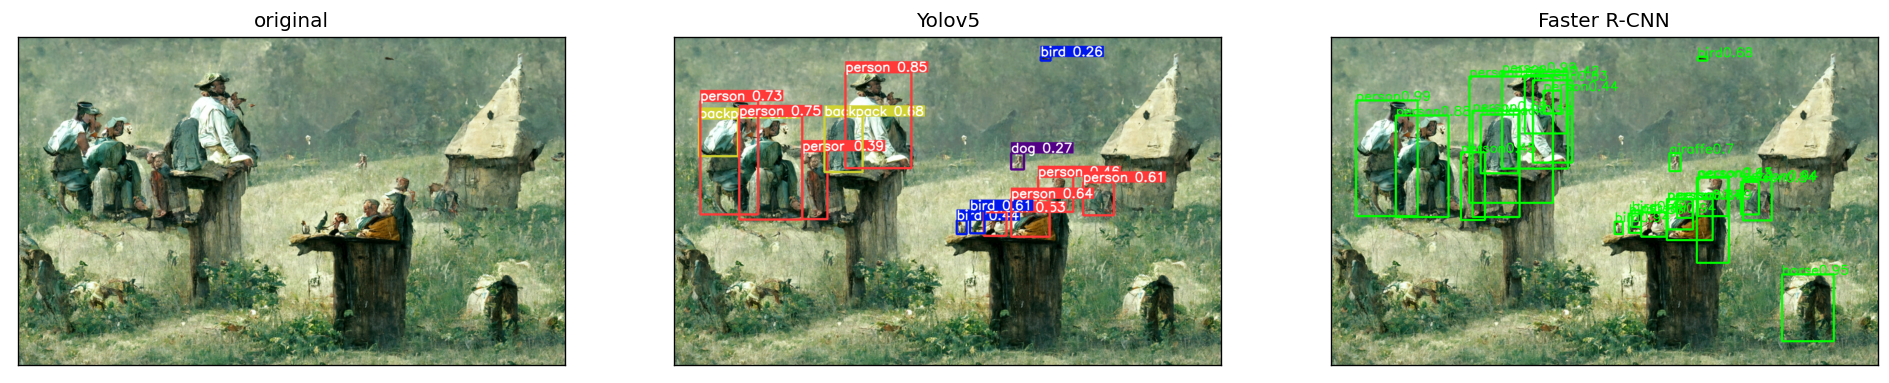

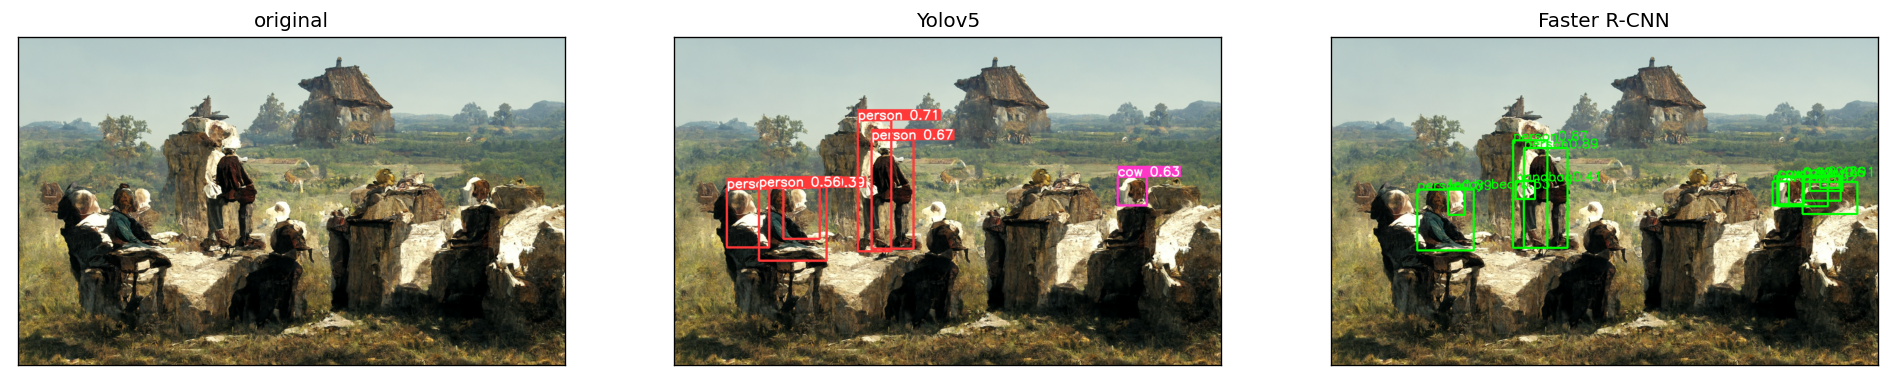

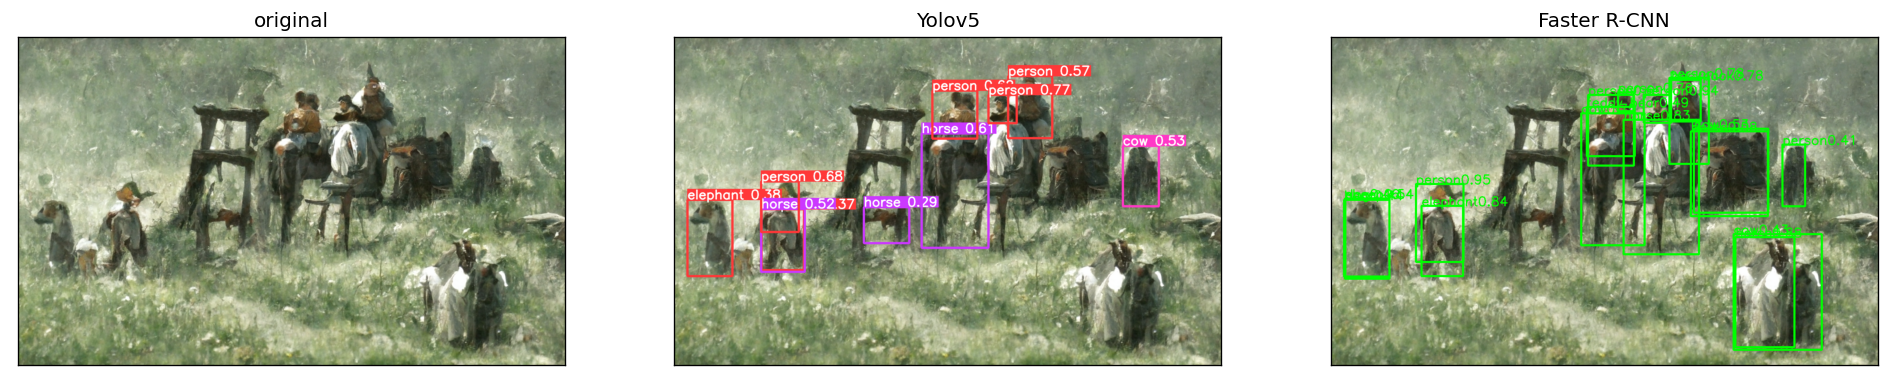

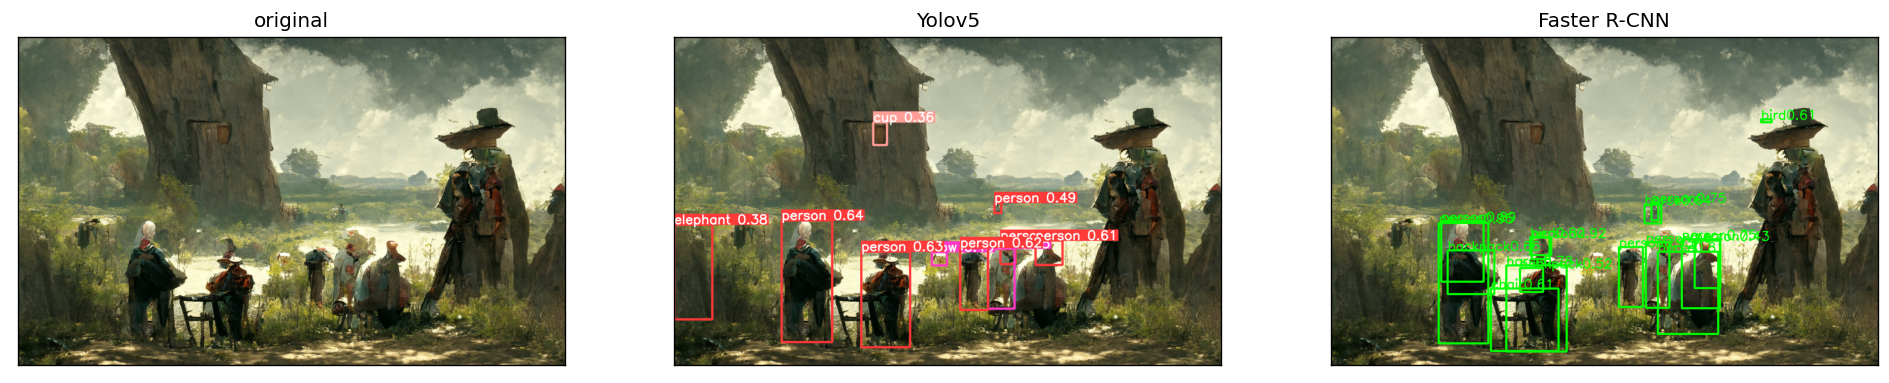

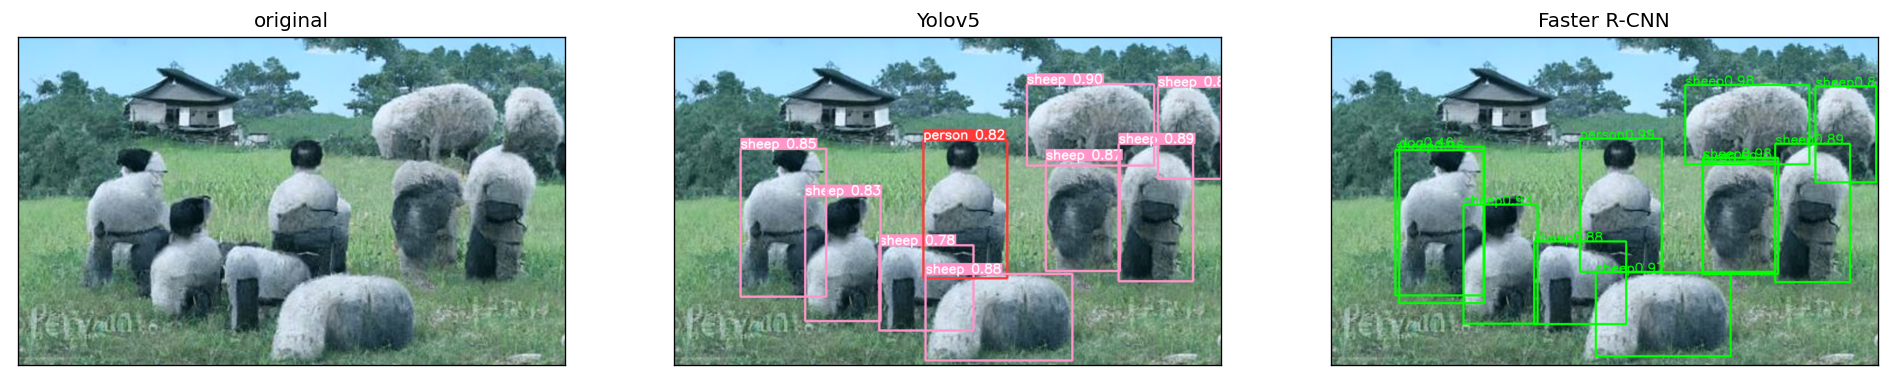

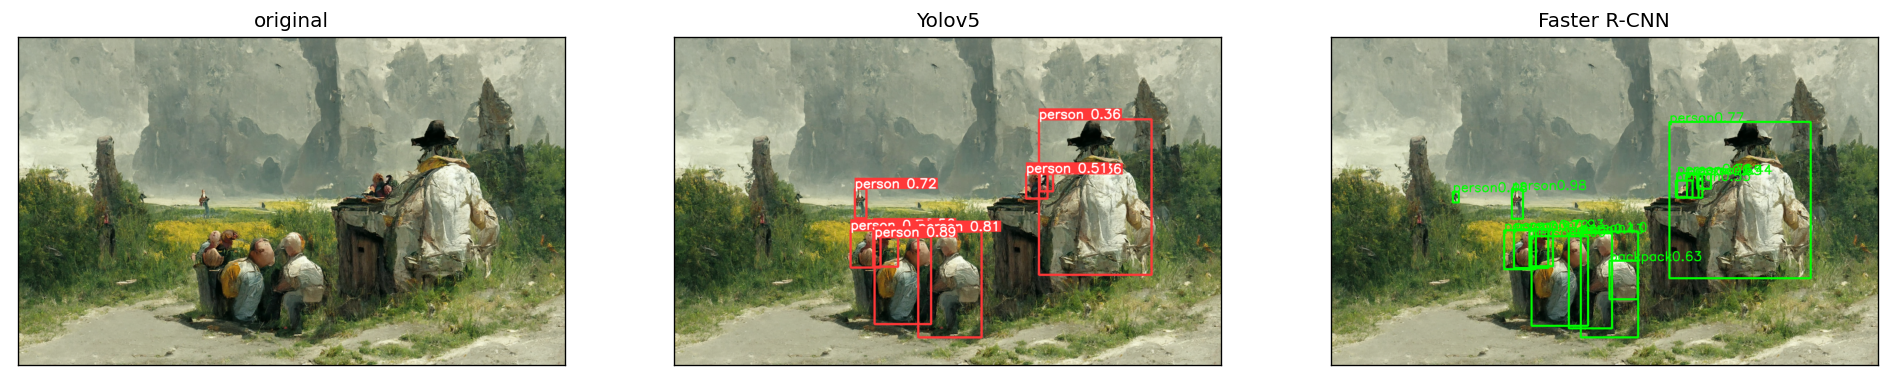

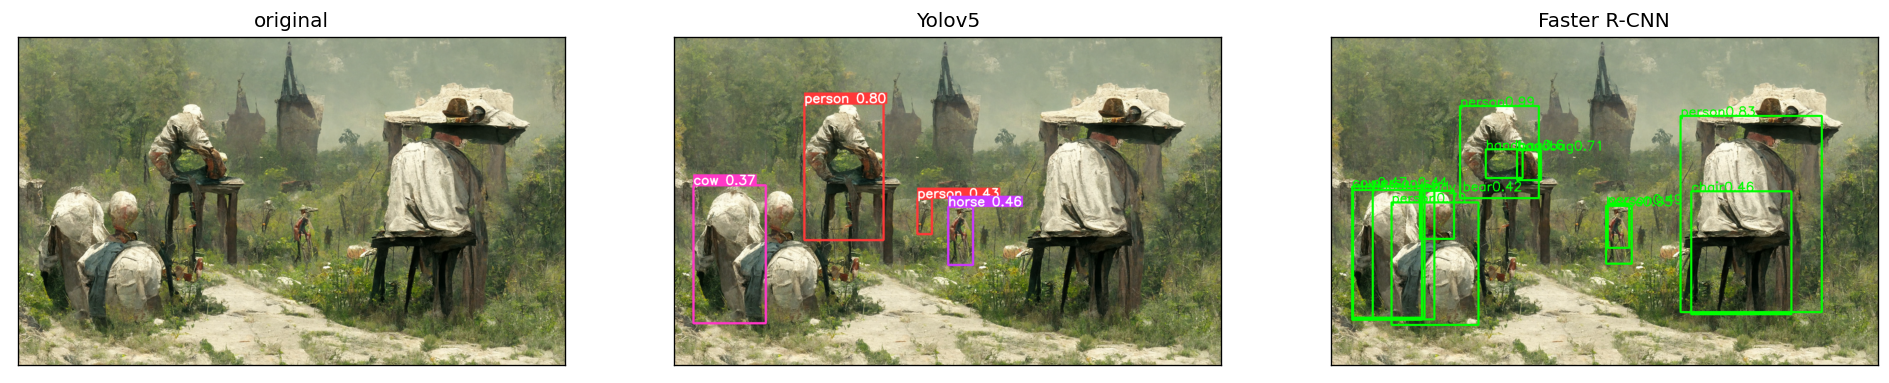

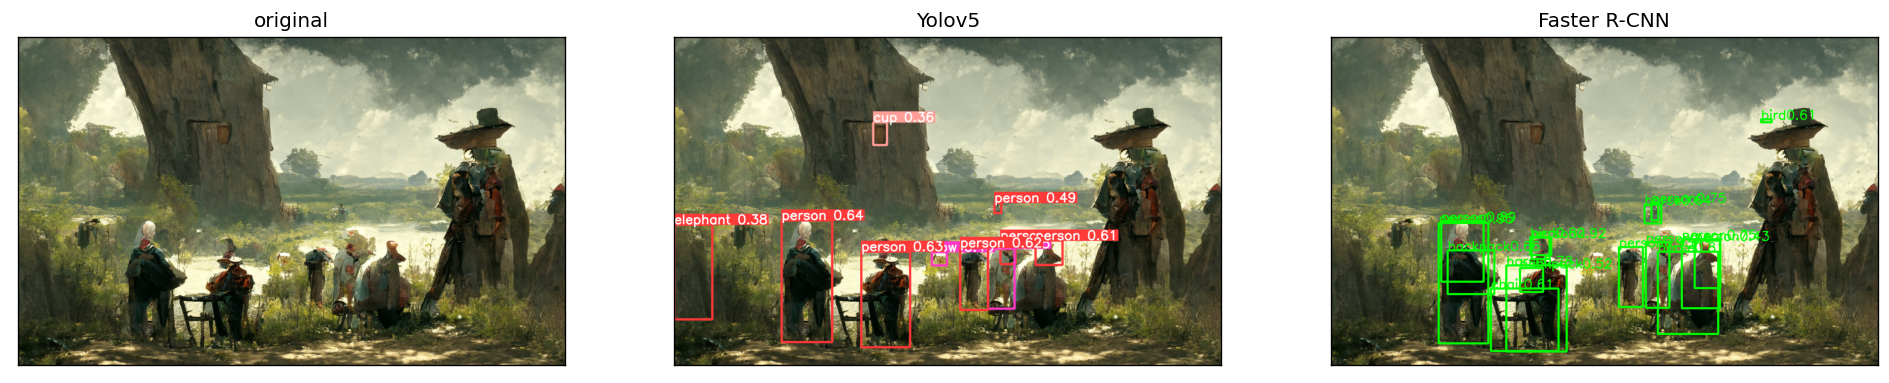

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
%matplotlib inline    


for i in range(len(imgs)):

  img1 = cv2.imread(imgs[i])
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = result.imgs[i]
  img3 = FasterRcnnImg[i]
  f, grid = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), dpi=120, sharex=True, sharey=True)
  grid[0].imshow(img1)
  grid[1].imshow(img2)
  grid[2].imshow(img3)

  grid[0].set_title("original")
  grid[1].set_title("Yolov5")
  grid[2].set_title("Faster R-CNN")
  plt.xticks([])
  plt.yticks([])
  plt.show()



# Generate Detection Result

In [ ]:
import pandas as pd
import numpy as np
table = dict()


#calculate result from yolov5
for eachImg in result.pandas().xyxy:
  for i in eachImg.index:
    if eachImg["name"][i] not in table:
      table[eachImg["name"][i]] = []
    table[eachImg["name"][i]].append(eachImg["confidence"][i])

#calculate result from FasterRcnn
for i in range(len(FRcnnCls)):
  for j in range(len(FRcnnCls[i])):
    className = FRcnnCls[i][j]
    classScore = FRcnnScore[i][j]
    if className not in table:
      table[className] = []
    table[className].append(classScore)

#calculate average
for eachItem in table:
  table[eachItem] = np.average(table[eachItem])

table = {k: v for k, v in sorted(table.items(),reverse = True, key=lambda item: item[1])}
print(table)

{'sheep': 0.8689107088481679, 'giraffe': 0.70205665, 'horse': 0.7016174674034119, 'person': 0.6995883820080521, 'bird': 0.6478808373212814, 'backpack': 0.6033390296830071, 'handbag': 0.57466173, 'cow': 0.5643924325704575, 'chair': 0.5582274, 'elephant': 0.48282191157341003, 'teddy bear': 0.47595146, 'bear': 0.43945998, 'dog': 0.3945181171099345, 'cup': 0.36173856258392334}


# T5 Sentence Generation

In [ ]:
# Input Construction
def tempGetInput(currentSentenceindex):
    return f"{genKeyword(demoStory.iloc[currentSentenceindex]['sentence'])} | {demoStory.iloc[currentSentenceindex]['context'].replace('|', ' ')} | {genEmo(demoStory.iloc[currentSentenceindex]['sentence'])}" 

In [ ]:
import transformers
import evaluate
from transformers import T5Tokenizer, T5ForConditionalGeneration
# ("mrm8488/t5-base-finetuned-common_gen")
tokenizer = T5Tokenizer.from_pretrained("Yuetian/T5-finetuned-storyCommonsense")
model = T5ForConditionalGeneration.from_pretrained("Yuetian/T5-finetuned-storyCommonsense")



def genSentence(words, max_length=32):
    input_text = words
    features = tokenizer([input_text], return_tensors='pt')

    output = model.generate(input_ids=features['input_ids'], 
                            attention_mask=features['attention_mask'],
                            max_length=max_length)

    return tokenizer.decode(output[0], skip_special_tokens=True)

def genStory(storyLength = 5):
    story = []
    story.append(demoSentence);
    for i in range(1, storyLength):
        story.append(genSentence(tempGetInput(i)))
    return story

def BLEU_metric(generatedText, actualText):
    bleu = evaluate.load("bleu")
    results = bleu.compute(predictions= generatedText, references= actualText)
    return results


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
def getBLEUEachSentence(actual, expected):
    return [BLEU_metric([x], [y])['bleu'] for x, y in zip(list(actual), list(expected))]

def getMeteorEachSentence(actual, expected):
    return  [meteor([word_tokenize(x)], word_tokenize(y)) for x, y in zip(list(actual), list(expected))]

In [ ]:
from pandas import DataFrame
from nltk.translate import meteor
from nltk import word_tokenize

testDatasetProcessed = DataFrame({"generated" : genStory(), "Ground truth": demoStory['sentence'].tolist()})
testDatasetProcessed['BLEU'] = getBLEUEachSentence(testDatasetProcessed["generated"], testDatasetProcessed["Ground truth"])
testDatasetProcessed['METEOR'] = getMeteorEachSentence(testDatasetProcessed["generated"], testDatasetProcessed["Ground truth"])
# TO-DO: add score to dataframe
testDatasetProcessed.style.set_properties(subset=['generated'], **{'width-min': '300px'})


In [ ]:
import pyarrow
pyarrow.__version__

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True